# Sea ice and mesoscale cyclones in ERA5

In [1]:
import cartopy.crs as ccrs
from datetime import datetime

from IPython.core.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr
from tqdm import tqdm_notebook as tqdm

from arke.cart import lcc_map, lcc_map_grid

from common_defs import winters, nyr, winter_dates
from plot_utils import LCC_KW, trans, clev101, abs_plt_kw, iletters
import mypaths
from stars_api import read_tracks_file

from octant.core import TrackRun, OctantTrack, HOUR
from octant.misc import calc_all_dens, SUBSETS, DENSITY_TYPES
import octant
octant.__version__

'0.0.10'

In [2]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='dask')
warnings.filterwarnings('ignore', category=UserWarning, module='iris')

In [3]:
# plt.style.use('paperfig.mplstyle')

In [4]:
lsm = xr.open_dataarray(mypaths.era5_dir / 'lsm.nc').squeeze()
lsm.attrs['units'] = 1
lon2d, lat2d = np.meshgrid(lsm.longitude, lsm.latitude)

### Get area weights to calculate the sea ice area

#### Calculate area weights using iris

In [5]:
import iris
from cf_units import Unit

In [6]:
lsm_cube = lsm.to_iris()

In [7]:
lsm_cube.coord('longitude').guess_bounds()
lsm_cube.coord('latitude').guess_bounds()

In [8]:
weights = lsm_cube.copy(data=iris.analysis.cartography.area_weights(lsm_cube, normalize=False))
weights.units = Unit('m^2')
weights.rename('area_weights')

Convert weights to $km^2$

In [9]:
weights.convert_units('km^2')

Convert to xarray dataarray

In [10]:
area_w = xr.DataArray.from_iris(weights)
area_w = area_w[(area_w.latitude >= 65) & (area_w.latitude <= 85), (area_w.longitude >= -20) & (area_w.longitude <= 50)]

## Load sea ice data

In [11]:
sea_ice_ds = xr.open_mfdataset(sorted(mypaths.era5_dir.glob('*.ci.nc')))

Extract sea ice cover array within the area used for tracking ($65-85N, 20W-50E$)

In [12]:
sea_ice_conc = sea_ice_ds.ci[:, (sea_ice_ds.latitude >= 65) & (sea_ice_ds.latitude <= 85), (sea_ice_ds.longitude >= -20) & (sea_ice_ds.longitude <= 50)]

### Sea ice area

By multiplying sea-ice cover variable from ERA5 by the area weights we obtain the **sea ice area**.

Note: this is not a sea ice extent (http://nsidc.org/arcticseaicenews/faq/#area_extent).

In [13]:
sic_thresh = 0.15  # 15% threshold

In [14]:
sea_ice_area = (sea_ice_conc * area_w).where(sea_ice_conc > sic_thresh, 0.)
# sea_ice_extent = (sea_ice_conc * 0.).where(sea_ice_conc < sic_thresh, 1.) * area_w

Get month numbers for each time step

In [15]:
month_series = sea_ice_area.time.dt.month

Create a boolen Dataaray that is true only during winter

In [16]:
extended_winter_mask = (month_series <= 4) | (month_series >= 10)

Mask the values not in winter and resample annualy starting in october

In [17]:
sea_ice_area_winter_mean = sea_ice_area.where(extended_winter_mask).resample(time='as-oct').mean('time')

In [18]:
sea_ice_conc_winter_mean = sea_ice_conc.where(extended_winter_mask).resample(time='as-oct').mean('time')

Add winter labels as an auxiliary coordinate

In [19]:
sea_ice_area_winter_mean['winter'] = ('time', winters)

In [20]:
total_sea_ice_area_over_winters = sea_ice_area_winter_mean.sum(dim=('longitude', 'latitude')) * 1e-6

### Calculate linear regression coeffiecients

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
lr_model = LinearRegression(fit_intercept=True)

In [23]:
x = np.array(range(total_sea_ice_area_over_winters.shape[0]))

In [24]:
lr_model.fit(x[:, np.newaxis], total_sea_ice_area_over_winters.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
sia_trend = lr_model.predict(x[:, np.newaxis])

In [26]:
print(f'Sea ice area decrease per year [10^6 km^2]: {lr_model.coef_[0]:4.3f}')

Sea ice area decrease per year [10^6 km^2]: -0.025


In [27]:
xlabels = [i.replace('_', '-') for i in total_sea_ice_area_over_winters.winter.values]

In [28]:
min_idx = total_sea_ice_area_over_winters.argmin(dim='time').values
winter_min = str(total_sea_ice_area_over_winters.winter[min_idx].values)
max_idx = total_sea_ice_area_over_winters.argmax(dim='time').values
winter_max = str(total_sea_ice_area_over_winters.winter[max_idx].values)

Select winters with extreme sea ice concentration

In [29]:
sia_minimum = sea_ice_area_winter_mean[sea_ice_area_winter_mean.winter==winter_min].squeeze()
sia_maximum = sea_ice_area_winter_mean[sea_ice_area_winter_mean.winter==winter_max].squeeze()

In [30]:
ci_minimum = sea_ice_conc_winter_mean[sea_ice_area_winter_mean.winter==winter_min].squeeze()
ci_maximum = sea_ice_conc_winter_mean[sea_ice_area_winter_mean.winter==winter_max].squeeze()

#### Create the plot

In [31]:
lcc_kw_t = LCC_KW.copy()
lcc_kw_t['ticks'] = [6, 3]

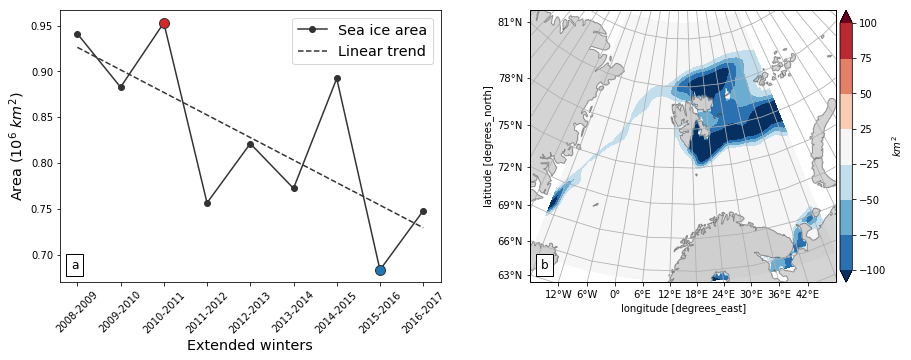

In [32]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
ax.plot(xlabels, total_sea_ice_area_over_winters, marker='o', color='#333333', label='Sea ice area')
ax.plot(xlabels, sia_trend, color='#333333', linestyle='--', label='Linear trend')
ax.plot(xlabels[max_idx], total_sea_ice_area_over_winters[max_idx], marker='o', mec='#333333', mfc='C3', ms=10)
ax.plot(xlabels[min_idx], total_sea_ice_area_over_winters[min_idx], marker='o', mec='#333333', mfc='C0', ms=10)
ax.legend(loc=1, fontsize='x-large')

ax.set_xlabel('Extended winters', fontsize='x-large')
ax.set_ylabel('Area ($10^6$ $km^2$)', fontsize='x-large')
ax.tick_params(axis='x', rotation=45)
ax.add_artist(AnchoredText('a', loc=3, prop=dict(size='large')))

ax = lcc_map(fig, 122, **lcc_kw_t)
h = (sia_minimum-sia_maximum).plot.contourf(ax=ax, extend='both',
                                            levels=clev101*100,
                                            add_colorbar=False,
                                            **trans)
cb = fig.colorbar(h, ax=ax, pad=0.01)
cb.ax.set_ylabel('$km^2$')
ax.add_artist(AnchoredText('b', loc=3, prop=dict(size='large')));

# fig.savefig(mypaths.plotdir / f'total_sea_ice_area_over_winters_era5')

In [33]:
total_sea_ice_area_over_winters[min_idx].values, total_sea_ice_area_over_winters[max_idx].values

(array(0.68322642), array(0.95311772))

## Load tracks

In [34]:
dataset = 'era5'

In [35]:
TR = TrackRun()
TR.data = OctantTrack.from_mux_df(pd.read_parquet(mypaths.procdir / 'era5_run000_2008_2017.parquet', engine='pyarrow'))

In [36]:
# TR_seaice_min = TrackRun()
# TR_seaice_min.data = TR.data[(TR.data['time'] >= winter_dates[winter_min][0]) & (TR.data['time'] <= winter_dates[winter_min][1])]

In [37]:
# TR_seaice_max = TrackRun()
# TR_seaice_max.data = TR.data[(TR.data['time'] >= winter_dates[winter_max][0]) & (TR.data['time'] <= winter_dates[winter_max][1])]

## Is the sea ice trend significant? Here we check this using a nonparametric resampling procedure (Monte Carlo method).

### Sea ice trend

In [38]:
import itertools as it
from math import factorial
from numpy.polynomial import polynomial as P

In [39]:
# def permutation_matrix(k):
#     f_k = math.factorial(k)
#     A = np.empty((k, f_k))
#     for i, perm in enumerate(it.permutations(range(k))):
#         A[:, i] = perm
#     return A

In [40]:
ci = total_sea_ice_area_over_winters.values

In [41]:
ci

array([0.94120279, 0.88284433, 0.95311772, 0.75642094, 0.82125429,
       0.77231725, 0.89237125, 0.68322642, 0.74785617])

In [42]:
(real_intercept, real_slope) = P.polyfit(np.arange(9), ci, 1)

In [43]:
perm_mat = np.array([*it.permutations(ci)])

In [44]:
(intercepts, slopes) = P.polyfit(np.arange(nyr), perm_mat.T, 1)

In [45]:
np.random.shuffle(slopes)

In [46]:
real_slope

-0.02463061373797954

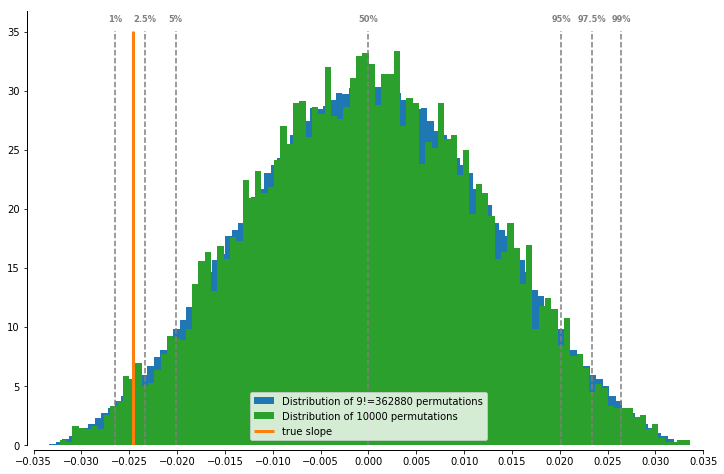

In [47]:
sub_n = 10000

fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(slopes, density=True, bins=100, label=f'Distribution of {nyr}!={len(slopes)} permutations')
ax.hist(slopes[:sub_n], density=True, bins=100, color='C2', label=f'Distribution of {sub_n} permutations')
for spine in ax.spines.values():
    if spine.spine_type in ['top', 'right']:
        spine.set_linewidth(0)
    else:
        spine.set_linewidth(1)
ax.spines['left'].set_position(('axes', -0.01))
ax.spines['bottom'].set_position(('axes', -0.01))
ax.set_xticks(np.arange(-0.035, 0.036, 0.005))
ax.set_xlim(-0.035, 0.035)

ymax = ax.get_ylim()[-1]

for perc in (1, 2.5, 5, 50, 95, 97.5, 99):
    x = np.percentile(slopes[:], perc)
    ax.vlines(x, 0, ymax, color='C7', linestyle='--')
    ax.annotate(f'{perc}%', (x, ymax+1),
                ha='center', va='center',
                fontweight='bold',
                color='C7',
                size='small')

ax.vlines(real_slope, 0, ymax, color='C1', linewidth=3, label='true slope')
ax.legend(loc=8)
# fig.savefig(mypaths.plotdir / 'sea_ice_slope_histogram.png', dpi=300, bbox_inches='tight')

The "real" slope of sea ice series linear regression is confident with 95% confidence.

### Maps

We have data averaged over 2008-2017 extended winters, i.e. the sample size is 9.

If we want to look at the difference of cyclone density between 2 extreme winters, the total number of combinations is
$$9C_2=\frac{9!}{7!\cdot2!}=36$$

Next, we can calculate the difference for each of the combinations and derive a distribution of values.
If the "real" difference is smaller than the 5-percentile or larger than 95-percentile (in the tails), it can be regarded as significant.

This is a test for **local** significance, which can be calculated at each grid point.
What about field significance?

#### Grids and arrays for density calculation

In [67]:
lon_dens = np.arange(-10, 41, 2.)
lat_dens = np.arange(65, 81, 1.)
lon_dens, lat_dens = np.meshgrid(lon_dens, lat_dens)

In [68]:
lsm_1deg = lsm.interp(coords=dict(longitude=lon_dens[0, :], latitude=lat_dens[:, 0])).to_iris()
lsm_1deg.coord('longitude').units = Unit('degrees_east')
lsm_1deg.coord('latitude').units = Unit('degrees_north')
lsm_1deg.coord('longitude').guess_bounds()
lsm_1deg.coord('latitude').guess_bounds()

In [69]:
weights = lsm_1deg.copy(data=iris.analysis.cartography.area_weights(lsm_1deg, normalize=False))
weights.units = Unit('m^2')
weights.rename('area_weights')
weights.convert_units('km^2')

In [70]:
area_weights_1deg = xr.DataArray.from_iris(weights)

In [71]:
area_weights_1deg_norm = xr.DataArray.from_iris(lsm_1deg.copy(data=iris.analysis.cartography.area_weights(lsm_1deg, normalize=True)))

In [72]:
lsm_1deg = xr.DataArray.from_iris(lsm_1deg)

#### Winter-average density

In [73]:
TR_one_winter = TrackRun()

_d = dict()
for winter, (winter_start, winter_end) in tqdm(winter_dates.items(), desc='winters'):
    TR_one_winter.data = TR.data[(TR.data['time'] >= winter_start) & (TR.data['time'] <= winter_end)]
    _d[winter] = calc_all_dens(TR_one_winter, lon_dens, lat_dens, method='radius', r=111.3)
dens_per_winter = xr.Dataset(_d).to_array(dim='winter').rename('density')
clear_output()

In [74]:
# da = dens_per_winter.sel(subset='moderate', dens_type='point')
da = dens_per_winter

In [75]:
pair_combinations = np.array([*it.combinations(winters, 2)])
pairs = [f'{j} minus {i}' for i, j in pair_combinations]

In [76]:
diffs = xr.DataArray(np.zeros((len(pair_combinations), *[j for i, j in da.sizes.items() if i != 'winter'])),
                     coords=(xr.IndexVariable(dims='winter_diff', data=pairs), da.subset, da.dens_type, da.latitude, da.longitude),
                     name='cyclone_density_difference')

In [77]:
# diffs = np.zeros((len(pair_combinations), *[j for i, j in da.sizes.items() if i != 'winter']))
for (winter0, winter1), winter_diff in zip(pair_combinations, pairs):
    diffs.sel(winter_diff=winter_diff)[:] = da.sel(winter=winter1) - da.sel(winter=winter0)
    #     diffs.i = da.values[idx1, ...] - da.values[idx0, ...]

In [78]:
actual_diff = diffs.sel(winter_diff=f'{winter_min} minus {winter_max}')

In [79]:
actual_confidence_mask = (((actual_diff <= np.percentile(diffs, 2.5, axis=0)) | (actual_diff >= np.percentile(diffs, 97.5, axis=0))) & (lsm_1deg.values < 1)).astype(int)
actual_confidence_mask.sel(subset='moderate', dens_type='lysis').sum()

<xarray.DataArray 'cyclone_density_difference' ()>
array(31)
Coordinates:
    winter_diff  <U25 '2015_2016 minus 2010_2011'
    subset       <U8 'moderate'
    dens_type    <U7 'lysis'

In [80]:
sel_kw = dict(subset='moderate', dens_type='genesis')

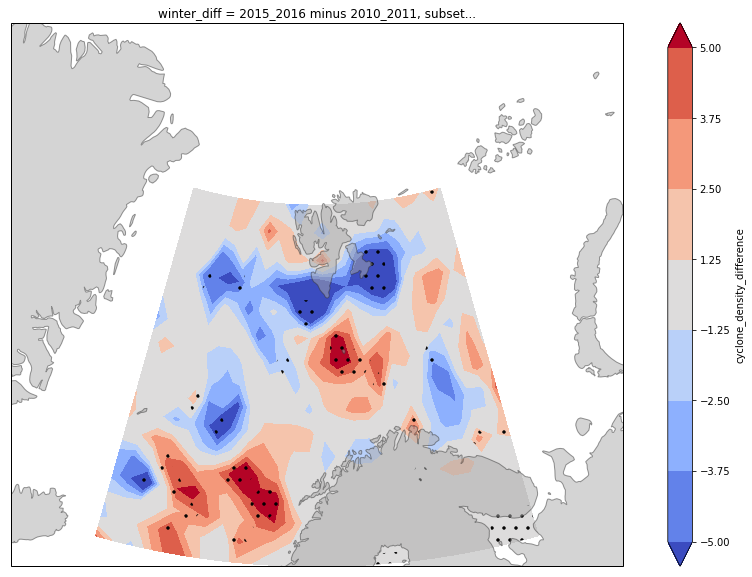

In [81]:
fig = plt.figure(figsize=(16, 10))

ax = lcc_map(fig, **LCC_KW)

actual_diff.sel(**sel_kw).plot.contourf(ax=ax, levels=clev101*round(np.percentile(actual_diff.sel(**sel_kw), 98)), extend='both', cmap='coolwarm', **trans)

actual_confidence_mask.sel(**sel_kw).plot.contourf(ax=ax, levels=[0, 0.5, 1.1], colors='none', hatches=[None, '.'], add_labels=False, add_colorbar=False, **trans)

### Field significance

In [82]:
null_dist_f = []

for i, d in enumerate(diffs):
    confidence_mask = (( (d <= np.percentile(diffs, 2.5, axis=0)) | (d >= np.percentile(diffs, 97.5, axis=0)) ) & (lsm_1deg < 1)).astype(int)
#     null_dist_f[i] = (area_weights_1deg_norm * confidence_mask).sum()
    null_dist_f.append((area_weights_1deg_norm * confidence_mask).sum(dim=('longitude', 'latitude')))
null_dist_f = xr.concat(null_dist_f, dim='winter_diff')

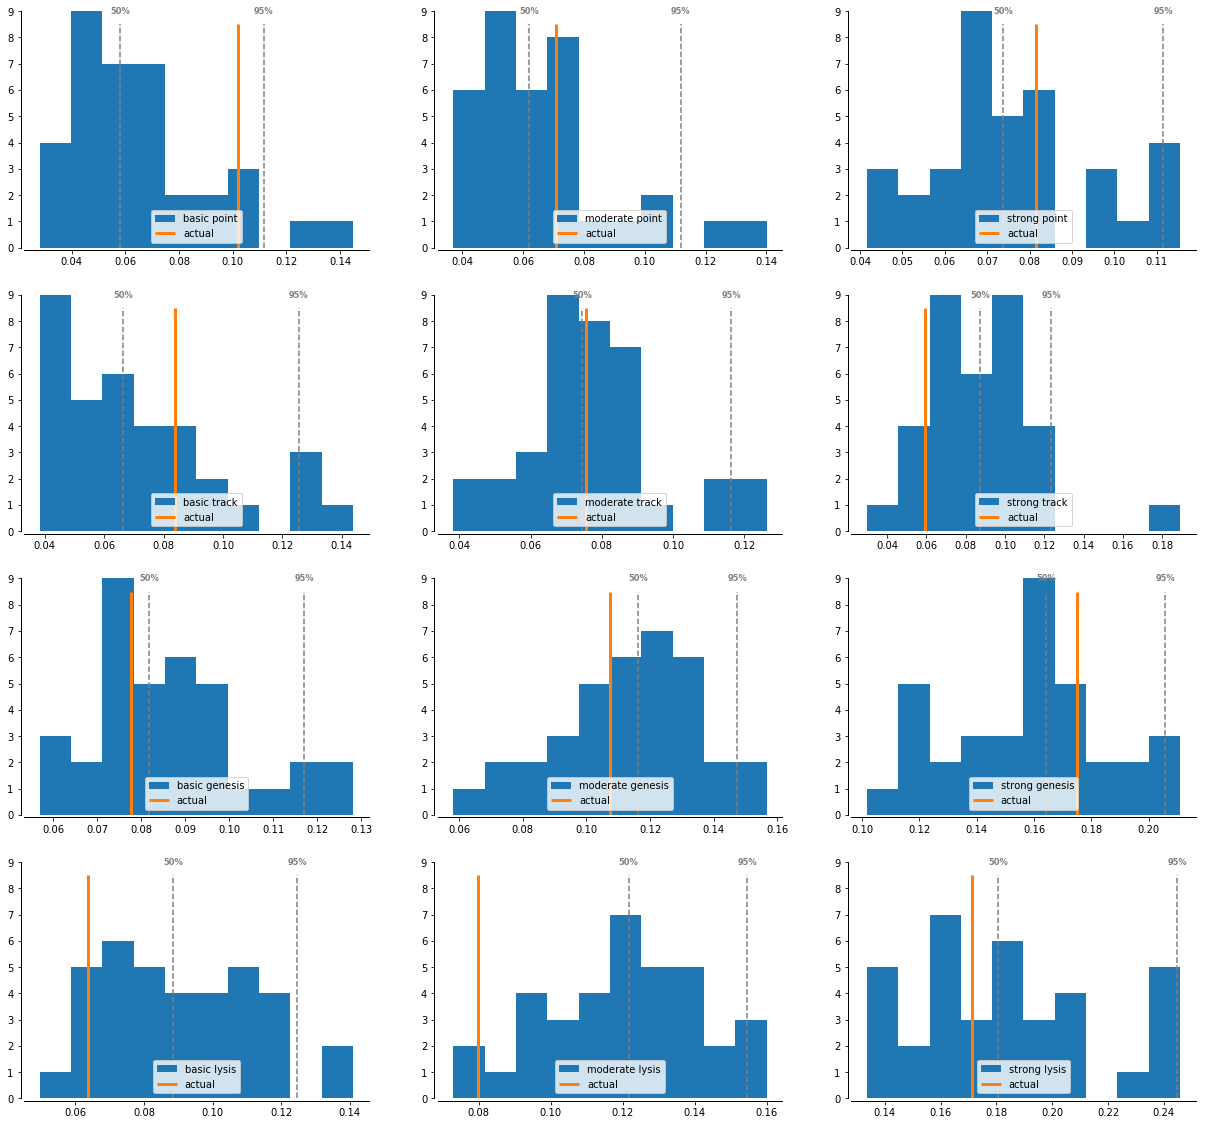

In [83]:
ncol = len(SUBSETS)
nrow = len(DENSITY_TYPES)


fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(7*ncol, 5*nrow))

for dens_type, axrow in zip(DENSITY_TYPES, axs):
    for subset, ax in zip(SUBSETS, axrow):
        sel_kw = dict(subset=subset, dens_type=dens_type)
        ax.hist(null_dist_f.sel(**sel_kw), label=f'{subset} {dens_type}')
        for spine in ax.spines.values():
            if spine.spine_type in ['top', 'right']:
                spine.set_linewidth(0)
            else:
                spine.set_linewidth(1)
        ax.spines['left'].set_position(('axes', -0.01))
        ax.spines['bottom'].set_position(('axes', -0.01))
#         ax.set_xticks(np.arange(0, 0.35, 0.05))
#         ax.set_xlim(0, 0.3)

        ymax = 9
        ax.set_ylim(0, ymax)

        for perc in (50, 95):
            x = np.percentile(null_dist_f.sel(**sel_kw), perc)
            ax.vlines(x, 0, ymax-0.5, color='C7', linestyle='--')
            ax.annotate(f'{perc}%', (x, ymax),
                        ha='center', va='center',
                        fontweight='bold',
                        color='C7',
                        size='small')

        ax.vlines(null_dist_f.sel(winter_diff=f'{winter_min} minus {winter_max}', **sel_kw), 0, ymax-0.5, color='C1', linewidth=3, label='actual')
        ax.legend(loc=8)

## Questions
* Autoregression
* Correlation
* Other tests?

In [95]:
np.tanh(1.96/6**0.5)

0.6641299261157337

## Plot density

In [45]:
AXGR_KW = dict(axes_pad=0.45,
               cbar_location='right',
               cbar_mode='each',
               cbar_pad=0.05,
               cbar_size='3%')

diff_plt_kw = dict(cmap='coolwarm', extend='both', **trans)
cntr_kw = dict(colors='#222222', linewidths=0.25, **trans)
cntr_lab_kw = dict(fmt='%3.0f', colors='k')
ci_kw = dict(levels=[0.15], linewidths=2, **trans)
at_kw = dict(loc=2, prop=dict(size='small'))

In [ ]:
subsets = SUBSETS[1:]

In [ ]:
ncol = len(subsets)
nrow = 4

for subset in subsets:
    fig = plt.figure(figsize=(ncol*7, nrow*5))
    axgr = lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)

    ax_labels = iter(string.ascii_lowercase)
    cbar_ax_iter = iter(axgr.cbar_axes)
    for axrow, dens_type in tqdm(zip(axgr.axes_row, DENSITY_TYPES), leave=False):

        ax = axrow[0]
        txt = f'({next(iletters)}) Sea ice maximum\n{winter_max.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_max.sel(subset=subset, dens_type=dens_type), **abs_plt_kw)
        levels = h.get_array()
        hh = ax.contour(lon_dens, lat_dens, minmax_dens.dens_max.sel(subset=subset, dens_type=dens_type), levels=levels, **cntr_kw)
        hhh = ax.clabel(hh, **cntr_lab_kw)
        plt.setp(hhh, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground='w')])
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_maximum.plot.contour(ax=ax, add_labels=False, colors='C3', **ci_kw)

        ax = axrow[1]
        txt = f'({next(iletters)}) Sea ice minimum\n{winter_min.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_min.sel(subset=subset, dens_type=dens_type), levels=levels, **abs_plt_kw)
        hh = ax.contour(lon_dens, lat_dens, minmax_dens.dens_min.sel(subset=subset, dens_type=dens_type), levels=levels, **cntr_kw)
        hhh = ax.clabel(hh, **cntr_lab_kw)
        plt.setp(hhh, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground='w')])
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_minimum.plot.contour(ax=ax, add_labels=False, colors='C9', **ci_kw)

        ax = axrow[2]
        txt = f'({next(iletters)}) Difference (min-max)\n{winter_min.replace("_", "-")} - {winter_max.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_diff.sel(subset=subset, dens_type=dens_type), **diff_plt_kw)
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_minimum.plot.contour(ax=ax, add_labels=False, colors='C9', **ci_kw)
        ci_maximum.plot.contour(ax=ax, add_labels=False, colors='C3', **ci_kw)

    # fig.savefig(mypaths.plotdir / f'pmctrack_{dataset}_seaice_minmaxdiff_density_{subset}')